<a href="https://colab.research.google.com/github/prateekmanral011/Earthquake-forecasting/blob/main/Probabilty_Estimation_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


⚠️ Removed 1 zero or negative inter-event times.


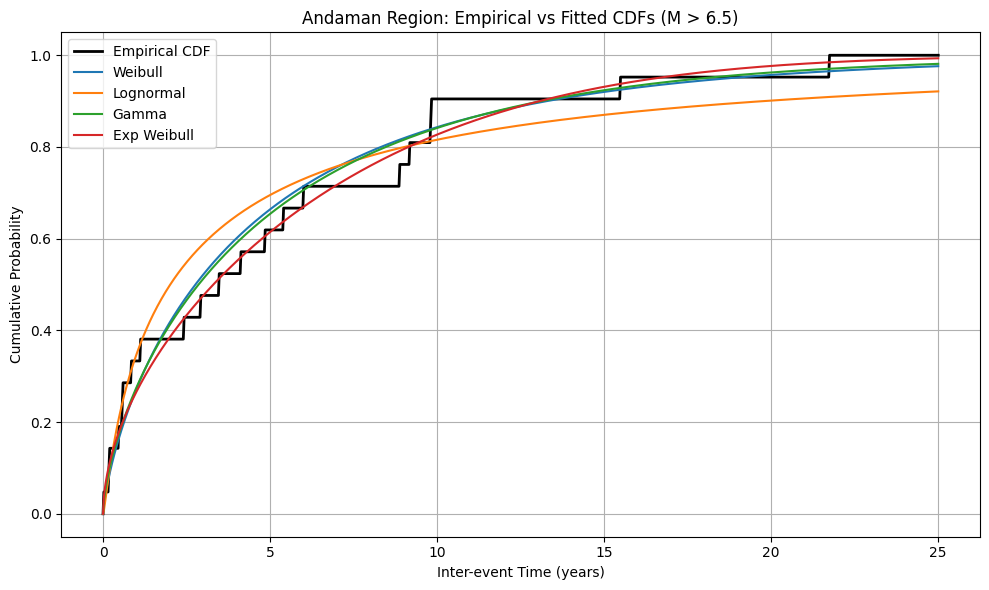


=== Parameter Summary ===
         Model   Param1  Param2  Param3  LogLikelihood
0      Weibull   4.4651  0.7652     NaN       -54.1114
1    Lognormal   0.6991  1.7828     NaN       -56.6199
2        Gamma   0.6510  7.8953     NaN       -53.8499
3  Exp Weibull  11.5387  1.7468  0.3093       -53.5666

=== AIC Comparison ===
         Model  Log-Likelihood  Parameters       AIC
2        Gamma        -53.8499           2  111.6998
0      Weibull        -54.1114           2  112.2228
3  Exp Weibull        -53.5666           3  113.1333
1    Lognormal        -56.6199           2  117.2398

✅ Total earthquakes with Mw > 7 used in analysis: 23

=== Conditional Probability Tables (τ as rows, T as columns) ===

 Weibull (Estimated)
       T=0     T=5    T=10    T=15
τ                                 
2   0.4178  0.2740  0.2423  0.2243
4   0.6012  0.4617  0.4197  0.3942
6   0.7145  0.5947  0.5516  0.5239
8   0.7904  0.6911  0.6510  0.6239
10  0.8433  0.7624  0.7265  0.7014

 Lognormal
       T=0

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import lognorm, gamma
from scipy.integrate import cumulative_trapezoid
from statsmodels.distributions.empirical_distribution import ECDF

# === Load and Filter CSV ===
df = pd.read_csv('/content/Andama.csv')  # ✅ Check this path on your Colab environment
df.columns = df.columns.str.strip().str.lower()
df = df.rename(columns={'mw': 'magnitude'})
df['date'] = pd.to_datetime(df['date'], format='mixed')

# 🔹 Filter earthquakes with Mw > 7


df = df[df['magnitude'] >6.5]


total_events = len(df)

# === Compute inter-event times in years ===
df = df.sort_values('date')
interevent_times_raw = df['date'].diff().dropna().dt.days / 365.25
interevent_times = interevent_times_raw[interevent_times_raw > 0].values

print(f"\n⚠️ Removed {len(interevent_times_raw) - len(interevent_times)} zero or negative inter-event times.")

# === ECDF ===
ecdf = ECDF(interevent_times)
x_vals = np.linspace(0, 25, 1000)

# === Weibull Model ===
def weibull_nll(params, data):
    a, b = params
    if a <= 0 or b <= 0:
        return np.inf
    return -np.sum(np.log((b / a) * (data / a)**(b - 1) * np.exp(-(data / a)**b)))

res_weibull = minimize(weibull_nll, [np.mean(interevent_times), 1], args=(interevent_times,), method='Nelder-Mead')
alpha_weibull, beta_weibull = res_weibull.x
loglike_weibull = -weibull_nll([alpha_weibull, beta_weibull], interevent_times)

# === Lognormal Model ===
shape_ln, loc_ln, scale_ln = lognorm.fit(interevent_times, floc=0)
mu_ln = np.log(scale_ln)
sigma_ln = shape_ln
loglike_lognorm = np.sum(lognorm.logpdf(interevent_times, shape_ln, loc_ln, scale_ln))

# === Gamma Model ===
shape_g, loc_g, scale_g = gamma.fit(interevent_times, floc=0)
loglike_gamma = np.sum(gamma.logpdf(interevent_times, shape_g, loc_g, scale_g))

# === Exponentiated Weibull Model ===
def exp_weibull_pdf(t, a, b, c):
    base = (b / a) * (t / a) ** (b - 1) * np.exp(-(t / a) ** b)
    factor = c * (1 - np.exp(-(t / a) ** b)) ** (c - 1)
    pdf = base * factor
    pdf[(t <= 0) | np.isnan(pdf) | np.isinf(pdf)] = 0
    return pdf

def exp_weibull_cdf(t, a, b, c):
    return (1 - np.exp(- (t / a)**b)) ** c

def exp_weibull_nll(params, data):
    a, b, c = params
    if any(p <= 0 for p in params):
        return np.inf
    pdf_vals = exp_weibull_pdf(data, a, b, c)
    if np.any(pdf_vals <= 0):
        return np.inf
    return -np.sum(np.log(pdf_vals))

res_ew = minimize(exp_weibull_nll, [np.mean(interevent_times), 1, 1],
                  args=(interevent_times,), method='L-BFGS-B', bounds=[(1e-5, None)] * 3)
a_ew, b_ew, c_ew = res_ew.x
loglike_ew = -exp_weibull_nll([a_ew, b_ew, c_ew], interevent_times)

# === Plot CDFs ===
plt.figure(figsize=(10, 6))
plt.plot(x_vals, ecdf(x_vals), label='Empirical CDF', color='black', lw=2)
plt.plot(x_vals, 1 - np.exp(-(x_vals / alpha_weibull)**beta_weibull), label='Weibull')
plt.plot(x_vals, lognorm.cdf(x_vals, shape_ln, loc_ln, scale_ln), label='Lognormal')
plt.plot(x_vals, gamma.cdf(x_vals, shape_g, loc_g, scale_g), label='Gamma')
plt.plot(x_vals, exp_weibull_cdf(x_vals, a_ew, b_ew, c_ew), label='Exp Weibull')
plt.xlabel('Inter-event Time (years)')
plt.ylabel('Cumulative Probability')


plt.title('Andaman Region: Empirical vs Fitted CDFs (M > 6.5)')





plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === Parameter Summary ===
summary = pd.DataFrame([
    {'Model': 'Weibull', 'Param1': alpha_weibull, 'Param2': beta_weibull, 'Param3': None, 'LogLikelihood': loglike_weibull},
    {'Model': 'Lognormal', 'Param1': mu_ln, 'Param2': sigma_ln, 'Param3': None, 'LogLikelihood': loglike_lognorm},
    {'Model': 'Gamma', 'Param1': shape_g, 'Param2': scale_g, 'Param3': None, 'LogLikelihood': loglike_gamma},
    {'Model': 'Exp Weibull', 'Param1': a_ew, 'Param2': b_ew, 'Param3': c_ew, 'LogLikelihood': loglike_ew}
])
print("\n=== Parameter Summary ===")
print(summary.round(4))

# === AIC Table ===
model_list = [
    ("Weibull", loglike_weibull, 2),
    ("Lognormal", loglike_lognorm, 2),
    ("Gamma", loglike_gamma, 2),
    ("Exp Weibull", loglike_ew, 3)
]
aic_df = pd.DataFrame([{
    "Model": name,
    "Log-Likelihood": logL,
    "Parameters": k,
    "AIC": 2 * k - 2 * logL
} for name, logL, k in model_list]).sort_values("AIC")

print("\n=== AIC Comparison ===")
print(aic_df.round(4))

# === Total Events Used ===



print(f"\n✅ Total earthquakes with Mw > 7 used in analysis: {total_events}")







# === Reversed Pivot: τ as rows, T as columns, grouped by model ===
def conditional_prob_table_reversed(models, T_vals, tau_vals):
    tables = {}
    for model_name, cdf_func in models:
        data = []
        for tau in tau_vals:
            row = {'τ': tau}
            for t in T_vals:
                if cdf_func(t) >= 1:
                    prob = 0.0
                else:
                    prob = (cdf_func(t + tau) - cdf_func(t)) / (1 - cdf_func(t))
                row[f"T={t}"] = round(prob, 4)
            data.append(row)
        tables[model_name] = pd.DataFrame(data).set_index('τ')
    return tables

# === Use same model list as before ===
cdf_models = [
    ("Weibull (Estimated)", lambda t: 1 - np.exp(-(t / alpha_weibull) ** beta_weibull)),
    #("Weibull (Beta=2.62)", lambda t: 1 - np.exp(-(t / alpha_weibull_fixed) ** known_beta)),
    ("Lognormal", lambda t: lognorm.cdf(t, shape_ln, loc=loc_ln, scale=scale_ln)),
    ("Gamma", lambda t: gamma.cdf(t, a=shape_g, loc=loc_g, scale=scale_g)),
    ("Exp Weibull", lambda t: (1 - np.exp(-(t / a_ew) ** b_ew)) ** c_ew)
]

T_vals = [0, 5, 10, 15]
tau_vals = [2, 4, 6, 8, 10]

# === Generate reversed tables ===
reversed_tables = conditional_prob_table_reversed(cdf_models, T_vals, tau_vals)

# === Print each model's table ===
print("\n=== Conditional Probability Tables (τ as rows, T as columns) ===")
for model_name, df_model in reversed_tables.items():
    print(f"\n {model_name}")
    print(df_model)




⚠️ Removed 0 zero or negative inter-event times.

=== Parameter Summary ===
         Model   Param1   Param2  Param3  Log-Likelihood
0      Weibull  14.7354   2.8664     NaN        -30.1812
1    Lognormal   2.4862   0.4324     NaN        -30.6678
2        Gamma   5.9868   2.1868     NaN        -30.3810
3  Exp Weibull  20.4656  10.6986  0.1688        -30.0151


/tmp/ipython-input-29-948601302.py:50: RuntimeWarning: divide by zero encountered in power
  factor = c * (1 - np.exp(- (t / a) ** b)) ** (c - 1)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


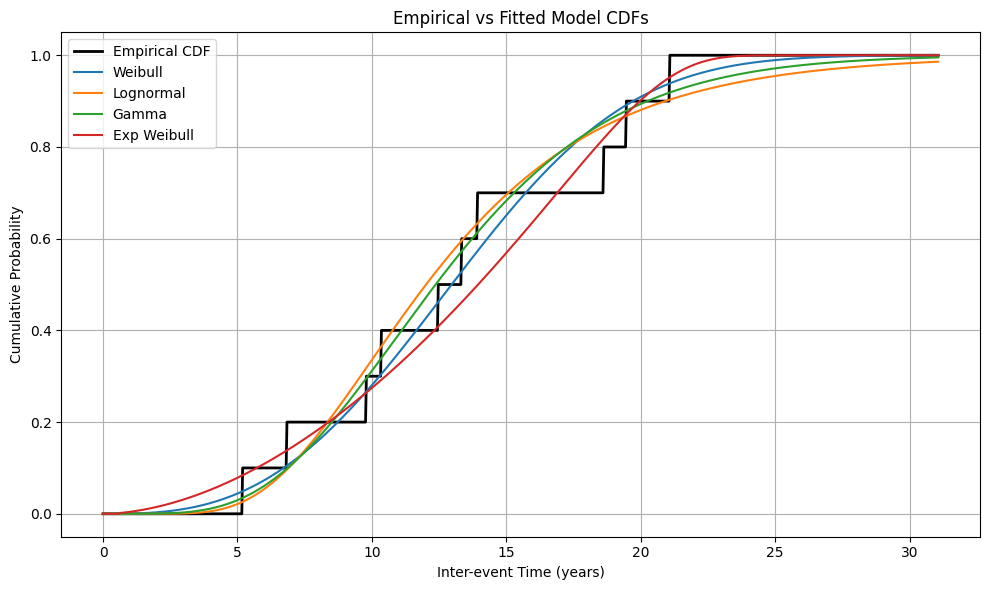


=== AIC Comparison ===
         Model  Log-Likelihood  Parameters      AIC
0      Weibull        -30.1812           2  64.3625
2        Gamma        -30.3810           2  64.7621
1    Lognormal        -30.6678           2  65.3356
3  Exp Weibull        -30.0151           3  66.0301

=== Conditional Probability Table ===
              Model  T (Elapsed)  Tau (Future)  P(T < t < T+τ | t > T)
0       cdf_weibull            0             2                  0.0033
1       cdf_weibull            0             4                  0.0235
2       cdf_weibull            0             6                  0.0733
3       cdf_weibull            0             8                  0.1594
4       cdf_weibull            0            10                  0.2805
..              ...          ...           ...                     ...
75  cdf_exp_weibull           15             2                  0.3208
76  cdf_exp_weibull           15             4                  0.6357
77  cdf_exp_weibull           15      

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import lognorm, gamma
from scipy.integrate import cumulative_trapezoid
from statsmodels.distributions.empirical_distribution import ECDF

# === Load CSV ===
df = pd.read_csv('/content/NE.csv')  # Replace with actual path
df.columns = df.columns.str.strip().str.lower()
df['date'] = pd.to_datetime(df['date'])

# === Sort and compute inter-event times in years ===
df = df.sort_values('date')
interevent_times_raw = df['date'].diff().dropna().dt.days / 365.25
interevent_times = interevent_times_raw[interevent_times_raw > 0].values

print(f"⚠️ Removed {len(interevent_times_raw) - len(interevent_times)} zero or negative inter-event times.")

# === Empirical CDF ===
ecdf = ECDF(interevent_times)
x_vals = np.linspace(0, interevent_times.max() + 10, 1000)

# === Weibull ===
def weibull_nll(params, data):
    a, b = params
    if a <= 0 or b <= 0:
        return np.inf
    return -np.sum(np.log(b / a * (data / a)**(b - 1) * np.exp(-(data / a)**b)))

res_weibull = minimize(weibull_nll, x0=[np.mean(interevent_times), 1.0],
                       args=(interevent_times,), method='Nelder-Mead')
alpha_weibull, beta_weibull = res_weibull.x
loglike_weibull = -weibull_nll([alpha_weibull, beta_weibull], interevent_times)

# === Lognormal ===
shape_ln, loc_ln, scale_ln = lognorm.fit(interevent_times, floc=0)
mu_ln = np.log(scale_ln)
sigma_ln = shape_ln
loglike_lognorm = np.sum(lognorm.logpdf(interevent_times, shape_ln, loc=loc_ln, scale=scale_ln))

# === Gamma ===
shape_g, loc_g, scale_g = gamma.fit(interevent_times, floc=0)
loglike_gamma = np.sum(gamma.logpdf(interevent_times, a=shape_g, loc=loc_g, scale=scale_g))

# === Exp Weibull ===
def exp_weibull_pdf(t, a, b, c):
    base = (b / a) * (t / a) ** (b - 1) * np.exp(- (t / a) ** b)
    factor = c * (1 - np.exp(- (t / a) ** b)) ** (c - 1)
    pdf = base * factor
    pdf[(t <= 0) | np.isnan(pdf) | np.isinf(pdf)] = 0
    return pdf

def exp_weibull_cdf(t, a, b, c):
    return (1 - np.exp(- (t / a)**b)) ** c

def exp_weibull_nll(params, data):
    a, b, c = params
    if any(p <= 0 for p in params):
        return np.inf
    pdf_vals = exp_weibull_pdf(data, a, b, c)
    if np.any(pdf_vals <= 0):
        return np.inf
    return -np.sum(np.log(pdf_vals))

res_ew = minimize(exp_weibull_nll, x0=[np.mean(interevent_times), 1, 1],
                  args=(interevent_times,), method='L-BFGS-B',
                  bounds=[(1e-5, None)] * 3)
a_ew, b_ew, c_ew = res_ew.x
loglike_ew = -exp_weibull_nll([a_ew, b_ew, c_ew], interevent_times)

# === Summary Table ===
summary = pd.DataFrame([
    {'Model': 'Weibull', 'Param1': alpha_weibull, 'Param2': beta_weibull, 'Param3': None, 'Log-Likelihood': loglike_weibull},
    {'Model': 'Lognormal', 'Param1': mu_ln, 'Param2': sigma_ln, 'Param3': None, 'Log-Likelihood': loglike_lognorm},
    {'Model': 'Gamma', 'Param1': shape_g, 'Param2': scale_g, 'Param3': None, 'Log-Likelihood': loglike_gamma},
    {'Model': 'Exp Weibull', 'Param1': a_ew, 'Param2': b_ew, 'Param3': c_ew, 'Log-Likelihood': loglike_ew}
])
print("\n=== Parameter Summary ===")
print(summary.round(4))

# === CDF Plot ===
plt.figure(figsize=(10, 6))
plt.plot(x_vals, ecdf(x_vals), label='Empirical CDF', color='black', lw=2)
plt.plot(x_vals, 1 - np.exp(-(x_vals / alpha_weibull)**beta_weibull), label='Weibull')
plt.plot(x_vals, lognorm.cdf(x_vals, shape_ln, loc_ln, scale_ln), label='Lognormal')
plt.plot(x_vals, gamma.cdf(x_vals, shape_g, loc_g, scale_g), label='Gamma')
plt.plot(x_vals, exp_weibull_cdf(x_vals, a_ew, b_ew, c_ew), label='Exp Weibull')

plt.xlabel('Inter-event Time (years)')
plt.ylabel('Cumulative Probability')
plt.title('Empirical vs Fitted Model CDFs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === AIC Table ===
model_info = [
    ("Weibull", loglike_weibull, 2),
    ("Lognormal", loglike_lognorm, 2),
    ("Gamma", loglike_gamma, 2),
    ("Exp Weibull", loglike_ew, 3)
]
aic_df = pd.DataFrame([{
    "Model": name,
    "Log-Likelihood": logL,
    "Parameters": k,
    "AIC": 2 * k - 2 * logL
} for name, logL, k in model_info]).sort_values("AIC")

print("\n=== AIC Comparison ===")
print(aic_df.round(4))

# === Conditional Probability Calculation ===
def conditional_prob_cdf(cdf_func, T_vals, tau_vals):
    results = []
    for T in T_vals:
        for tau in tau_vals:
            t1 = T
            t2 = T + tau
            if cdf_func(t1) >= 1.0:
                cond_prob = 0.0
            else:
                cond_prob = (cdf_func(t2) - cdf_func(t1)) / (1 - cdf_func(t1))
            results.append({
                "Model": cdf_func.__name__,
                "T (Elapsed)": t1,
                "Tau (Future)": tau,
                "P(T < t < T+τ | t > T)": cond_prob
            })
    return pd.DataFrame(results)

def cdf_weibull(t): return 1 - np.exp(-(t / alpha_weibull) ** beta_weibull)
def cdf_lognorm(t): return lognorm.cdf(t, shape_ln, loc=loc_ln, scale=scale_ln)
def cdf_gamma(t): return gamma.cdf(t, a=shape_g, loc=loc_g, scale=scale_g)
def cdf_exp_weibull(t): return (1 - np.exp(- (t / a_ew) ** b_ew)) ** c_ew

T_vals = [0, 5, 10, 15]
tau_vals = [2, 4, 6, 8, 10]

df_weibull = conditional_prob_cdf(cdf_weibull, T_vals, tau_vals)
df_lognorm = conditional_prob_cdf(cdf_lognorm, T_vals, tau_vals)
df_gamma = conditional_prob_cdf(cdf_gamma, T_vals, tau_vals)
df_exp_weibull = conditional_prob_cdf(cdf_exp_weibull, T_vals, tau_vals)

cond_prob_df = pd.concat([df_weibull, df_lognorm, df_gamma, df_exp_weibull], ignore_index=True)
print("\n=== Conditional Probability Table ===")
print(cond_prob_df.round(4))
